# Trading Algorithm Exercise 
** This is an extremely open exercise and there are lots of ways to do it! Please feel free to just skip to the solutions to treat it as an example code along. If you attempt the exercise, do not expect the example solution to exactly match up to your solution. You may have performed much better (or much worse)! **

## Your Task

Your manager wants to see if [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands) are still a meaningful technical analysis strategy on their own. For this exercise, you will be testing *Johnson and Johnson* sid(4151).Specifically, your manager has decided he wants set 100% of the portfolio to go long when the stock price is below 2 times the 20 day rolling standard deviation subtracted from the 20 day moving average, and go 100% short of the portfolio on that stock when the current price is above 2 times the 20 day rolling standard deviation added on to the 20 day moving average. The check for this signal event should only happen once per day. This is probably a very unreasonable strategy, but the main point of this is to exercise your ability to write out backtest algorithms with Quantopian.

## Time Frame

You should use the following time frame for this exercise (so you can at least have a reasonable comparison to the solutions, but feel free to play around with this!)

#### BACKTEST START:  Jul-20-2014
#### BACKTEST END: Jul-20-2017

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import yfinance as yf

In [4]:
start = '2015-01-07'
end = '2017-01-07'

In [6]:
stocks = yf.download('JNJ', start=start, end=end)
stocks.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,JNJ,JNJ,JNJ,JNJ,JNJ
Date,,,,,
2015-01-07,80.100388,80.305271,78.772463,78.848349,7931700
2015-01-08,80.730194,80.806074,80.244554,80.479784,9916000
2015-01-09,79.629944,80.813692,79.485767,80.813692,7364800
2015-01-12,79.356773,80.297701,79.144306,79.804471,6839000
2015-01-13,79.493355,80.684693,79.098768,80.009349,10151100


<Axes: xlabel='Date'>

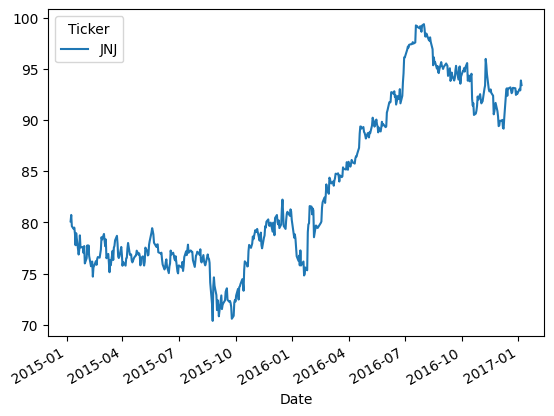

In [7]:
stocks['Close'].plot()

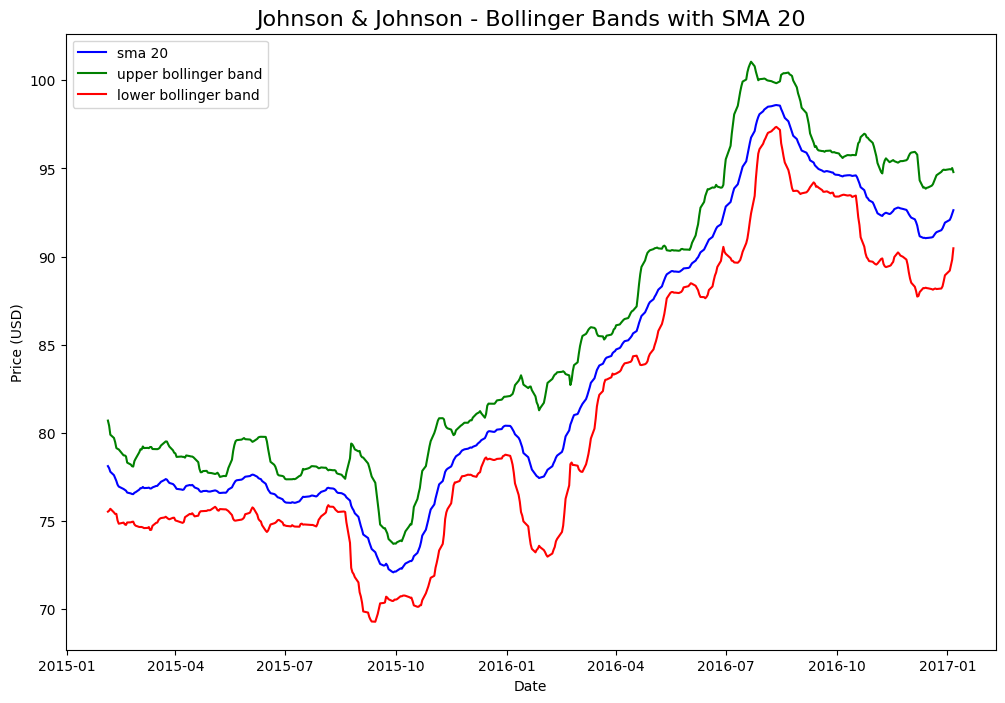

In [23]:
# Calculate the 20-period Simple Moving Average (SMA)
stocks_sma20 = stocks['Close'].rolling(20).mean()

# Calculate the rolling standard deviation for the same period
stocks_std20 = stocks['Close'].rolling(20).std()

# Calculate the upper and lower Bollinger Bands
upper_band = stocks_sma20 + (2 * stocks_std20)
lower_band = stocks_sma20 - (2 * stocks_std20)

plt.figure(figsize=(12,8))
plt.plot(stocks_sma20,label='sma 20',c='b')
plt.plot(upper_band,label='upper bollinger band',c='g')
plt.plot(lower_band,label='lower bollinger band',c='r')
plt.plot()
plt.legend()

# Adding labels and title
plt.title('Johnson & Johnson - Bollinger Bands with SMA 20', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

# Display the plot
plt.show()

In [ ]:
from blueshift.api import (
    symbol,
    order_target_percent,
    schedule_function,
    date_rules,
    time_rules,
    record,
)
from blueshift.library.technicals.indicators import bollinger_band
import numpy as np

def initialize(context):
    """
    This function will run once at the beginning of the backtest.
    """
    # Define the stock (Johnson & Johnson in this case)
    context.stock = symbol('AAPL')
    
    # Define strategy parameters
    context.params = {
        'bbands_period': 20,  # Bollinger Bands period
        'bbands_dev': 2,      # Number of standard deviations for the bands
        'trade_freq': 1,      # Frequency of trading (every 5 minutes)
    }
    
    # Schedule the function to check the strategy every minute
    schedule_function(run_strategy, date_rules.every_day(),
                      time_rules.market_close(minutes=30))
def run_strategy(context, data):
    """
    Function to implement the trading logic for the strategy.
    """
    # Get historical price data
    price_data = data.history(context.stock, 'close', context.params['bbands_period'], '1m')
    
    # Calculate Bollinger Bands
    upper_band, middle_band, lower_band = bollinger_band(price_data, context.params['bbands_period'], context.params['bbands_dev'])
    
    # Get the current price
    current_price = price_data[-1]
    
    # Check if we should buy (price is below the lower band)
    if current_price < lower_band:
        # Buy signal: We place a buy order for 100% of the portfolio in the stock
        order_target_percent(context.stock, 1)
        
    # Check if we should sell (price is above the upper band)
    elif current_price > upper_band:
        # Sell signal: We place a sell order to close the position
        order_target_percent(context.stock, -1)
    
    # Exit condition (when price moves between bands)
    elif current_price == middle_band:  # Corrected to use '==' for comparison
        # Close any positions if the price moves between the bands
        order_target_percent(context.stock, 0)

    # Record relevant data for analysis (for plotting or reporting)
    record(price=current_price, upper_band=upper_band, lower_band=lower_band)

def handle_data(context, data):
    """
    Handle data after market close or during specific actions (optional).
    """
    pass
